# Week 3 Assignment

### DSC 630

### Darin Young 

### Using Data to Improve MLB Attendance

The goal of this assignment is to utilize a dataset from the Los Angeles Dodgers to make a recommendation as to the best way(s) to improve attendance. The dataset is from 2022 and shows attendance values for each game as well as variables like temperature, giveaways, time of day, etc. My hope is to make a recommendation to management one or more ways to improve attendance at future games. 

For reference, here is a quick look at the data. 

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv("dodgers-2022.csv")
df

,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead
0,APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,NO,NO
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,NO,NO
2,APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,NO,NO
3,APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,YES,NO
4,APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
76,SEP,29,40724,Saturday,Rockies,84,Cloudy,Night,NO,NO,NO,NO
77,SEP,30,35607,Sunday,Rockies,95,Clear,Day,NO,NO,NO,NO
78,OCT,1,33624,Monday,Giants,86,Clear,Night,NO,NO,NO,NO
79,OCT,2,42473,Tuesday,Giants,83,Clear,Night,NO,NO,NO,NO


## Step 1: Data Cleaning/Prep

As shown, there are many variables in this dataset that might impact attendance. For this analysis, I am only interested in the ones that management has some control over. So, I will be excluding the following variables:

1. Month/Day - These may have some impact on attendance (summer games might have more attendance because kids are out of school, for example), but LA Dodgers management can not change their schedule to take advantage of these trends. Baseball is played from April - October and that's decided by the MLB, not the Dodgers.
2. day_of_week - Similar to above, the specific day of the week is really out of the Dodgers control. I'm confident that (if included) we would find that weekend games have higher attendance than weekday games. However, it's impossible for the Dodgers to schedule more games on weekends because weekends are a finite resource (only so many weekends in a regular season of baseball).
3. Opponent - As above, the Dodgers can't control who they play and can't schedule the more popular opponents to increase attendance.
4. Temp/skies - Should be self-explanatory, the Dodgers can't control the weather.
5. day_night - This one is on the fringe of being excluded. I believe management has some say as to the time of day that games are played (or at least a general rule that is applied across their schedule overall). So, I could see an argument for including or excluding this one - but I'll include it. 

With all of this in mind, this is the updated dataset with only the relevant columns. 

In [10]:
df.drop(['month', 'day', 'day_of_week', 'opponent', 'temp', 'skies'], axis=1, inplace=True)
df

,attend,day_night,cap,shirt,fireworks,bobblehead
0,56000,Day,NO,NO,NO,NO
1,29729,Night,NO,NO,NO,NO
2,28328,Night,NO,NO,NO,NO
3,31601,Night,NO,NO,YES,NO
4,46549,Night,NO,NO,NO,NO
...,...,...,...,...,...,...
76,40724,Night,NO,NO,NO,NO
77,35607,Day,NO,NO,NO,NO
78,33624,Night,NO,NO,NO,NO
79,42473,Night,NO,NO,NO,NO


Before I move on, I'd like to convert each of the columns into 1/0 flags to make visualizing and modeling more simple. 

In [12]:
def day_night_categorizer(value):
    if value == "Day":
        return 1
    elif value == "Night":
        return 0
    else:
        return 99

In [13]:
df['day_night_numeric'] = df['day_night'].apply(day_night_categorizer)
df

,attend,day_night,cap,shirt,fireworks,bobblehead,day_night_numeric
0,56000,Day,NO,NO,NO,NO,1
1,29729,Night,NO,NO,NO,NO,0
2,28328,Night,NO,NO,NO,NO,0
3,31601,Night,NO,NO,YES,NO,0
4,46549,Night,NO,NO,NO,NO,0
...,...,...,...,...,...,...,...
76,40724,Night,NO,NO,NO,NO,0
77,35607,Day,NO,NO,NO,NO,1
78,33624,Night,NO,NO,NO,NO,0
79,42473,Night,NO,NO,NO,NO,0


In [14]:
df['day_night_numeric'].unique()

array([1, 0], dtype=int64)

This has worked as intended - all day/night values have been encoded as 1s if day and 0s if night. 

In [16]:
def giveaway_categorizer(value):
    if value == "YES":
        return 1
    elif value == "NO":
        return 0
    else:
        return 99

In [17]:
df['cap_numeric'] = df['cap'].apply(giveaway_categorizer)
df['shirt_numeric'] = df['shirt'].apply(giveaway_categorizer)
df['fireworks_numeric'] = df['fireworks'].apply(giveaway_categorizer)
df['bobblehead_numeric'] = df['bobblehead'].apply(giveaway_categorizer)
df

,attend,day_night,cap,shirt,fireworks,bobblehead,day_night_numeric,cap_numeric,shirt_numeric,fireworks_numeric,bobblehead_numeric
0,56000,Day,NO,NO,NO,NO,1,0,0,0,0
1,29729,Night,NO,NO,NO,NO,0,0,0,0,0
2,28328,Night,NO,NO,NO,NO,0,0,0,0,0
3,31601,Night,NO,NO,YES,NO,0,0,0,1,0
4,46549,Night,NO,NO,NO,NO,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
76,40724,Night,NO,NO,NO,NO,0,0,0,0,0
77,35607,Day,NO,NO,NO,NO,1,0,0,0,0
78,33624,Night,NO,NO,NO,NO,0,0,0,0,0
79,42473,Night,NO,NO,NO,NO,0,0,0,0,0


In [18]:
print(df['cap_numeric'].unique())
print(df['shirt_numeric'].unique())
print(df['fireworks_numeric'].unique())
print(df['bobblehead_numeric'].unique())

[0 1]
[0 1]
[0 1]
[0 1]


As above, all values have been categorized as 0s or 1s. Now that this has been done, I can remove the original columns to keep this consolidated. 

In [20]:
df.drop(['day_night', 'cap', 'shirt', 'fireworks', 'bobblehead'], axis=1, inplace=True)
df

,attend,day_night_numeric,cap_numeric,shirt_numeric,fireworks_numeric,bobblehead_numeric
0,56000,1,0,0,0,0
1,29729,0,0,0,0,0
2,28328,0,0,0,0,0
3,31601,0,0,0,1,0
4,46549,0,0,0,0,0
...,...,...,...,...,...,...
76,40724,0,0,0,0,0
77,35607,1,0,0,0,0
78,33624,0,0,0,0,0
79,42473,0,0,0,0,0


## Step 2: Data Exploration

Now that we've got the data how we want it, we can start doing some exploration. My goal in this step is to evaluate each variable individually to see how it might impact attendance. This will help when I look to build a regression model in a later step. 

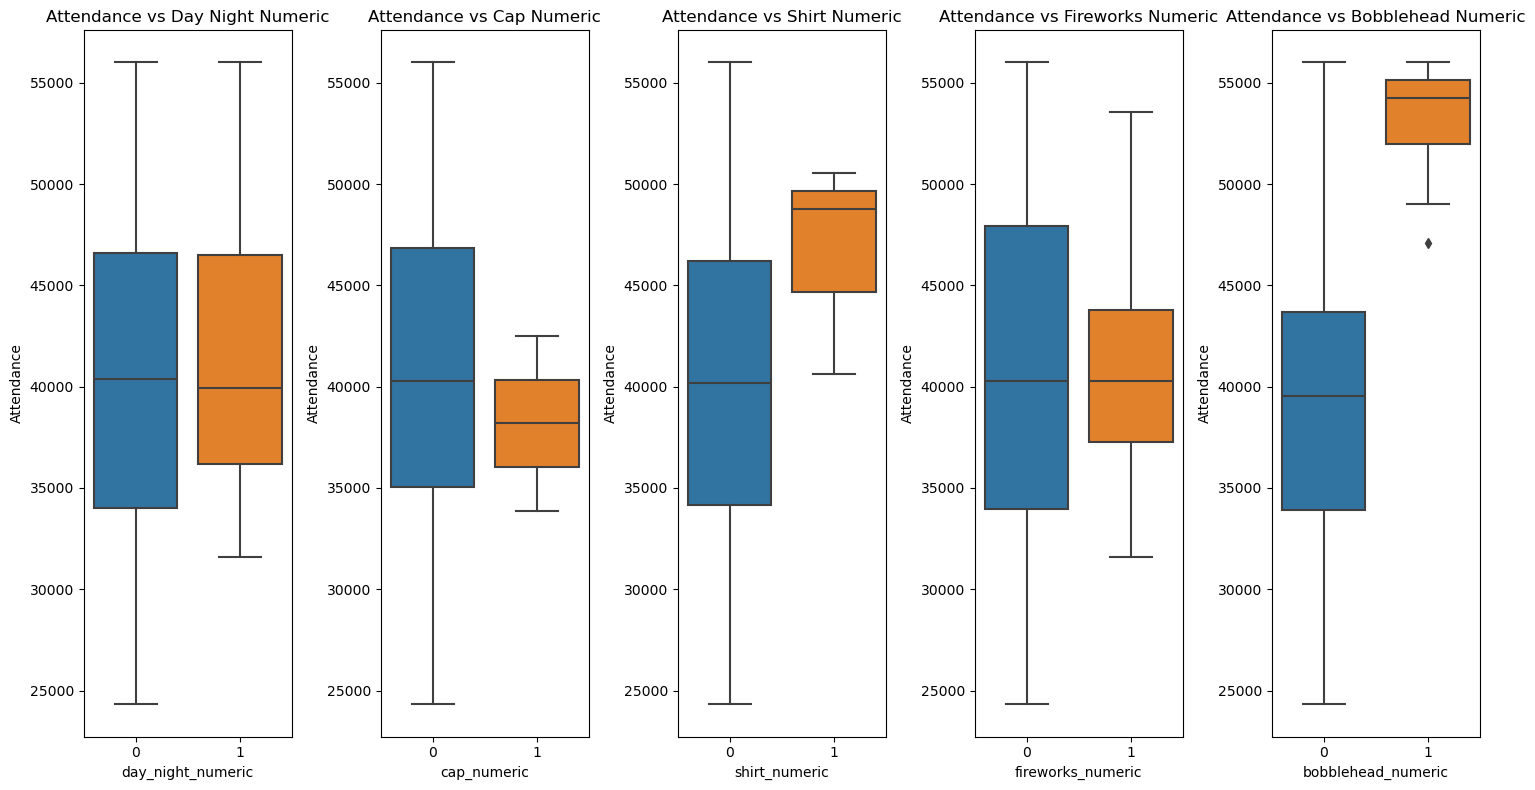

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

categorical_vars = ['day_night_numeric', 'cap_numeric', 'shirt_numeric', 'fireworks_numeric', 'bobblehead_numeric']

plt.figure(figsize=(15, 8))
n_vars = len(categorical_vars)

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(1, n_vars, i)
    sns.boxplot(x=var, y='attend', data=df)
    plt.ylabel("Attendance")
    plt.title(f"Attendance vs {var.replace('_', ' ').title()}")

plt.tight_layout()
plt.show()

Here are my observations based on these box plots:

1. Night games have a higher floor, but average attendance is still essentially the same.
2. Games in which the Dodgers give away hats and/or shoot fireworks after the game seem to have little, if any, impact on attendance.
3. Games in which the Dodgers give away shirts or bobbleheads seem to increase attendance quite a bit, with bobblehead games being the highest visual impact.

From here, I'd like to see how the variables are correlated with attendance, if at all. 

                      attend  day_night_numeric  cap_numeric  shirt_numeric  \
attend              1.000000           0.043544    -0.055002       0.133269   
day_night_numeric   0.043544           1.000000     0.128951       0.074796   
cap_numeric        -0.055002           0.128951     1.000000      -0.031204   
shirt_numeric       0.133269           0.074796    -0.031204       1.000000   
fireworks_numeric   0.002094          -0.217922    -0.072732      -0.089648   
bobblehead_numeric  0.581895          -0.188982    -0.063074      -0.077743   
attendance_high     0.819419          -0.025898     0.001964       0.198552   

                    fireworks_numeric  bobblehead_numeric  attendance_high  
attend                       0.002094            0.581895         0.819419  
day_night_numeric           -0.217922           -0.188982        -0.025898  
cap_numeric                 -0.072732           -0.063074         0.001964  
shirt_numeric               -0.089648           -0.077743  

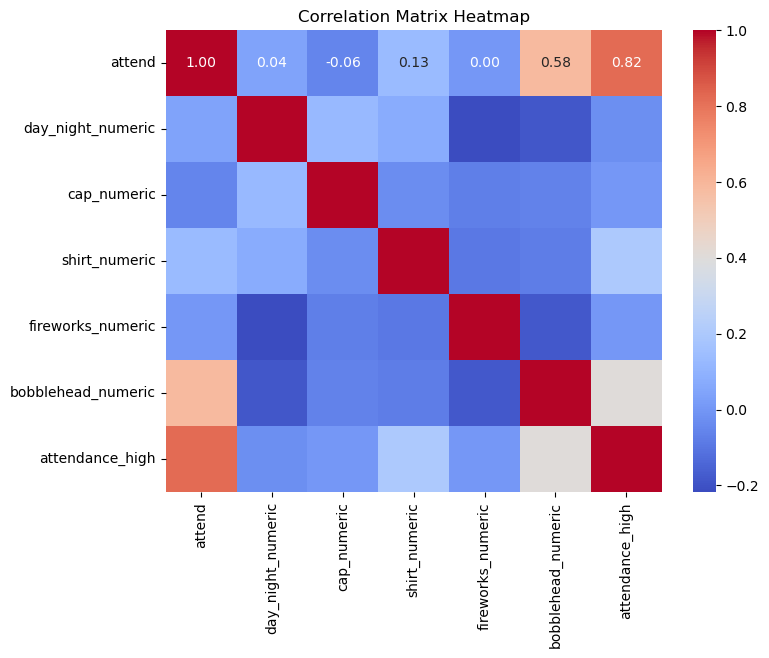

In [96]:
correlation_matrix = df.corr()
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

The correlation map shown seems to only reinforce that bobblehead games have the highest correlation with increases in attendance. With that in mind, I must add that the sample size is small, as shown below. 

In [94]:
bobblehead_count = df[df['bobblehead_numeric'] == 1].shape[0]
total_games = df.shape[0]

print(f"Number of bobblehead games: {bobblehead_count}")
print(f"Total games in dataset: {total_games}")

Number of bobblehead games: 11
Total games in dataset: 81


Although bobblehead games seem to have a high impact on attendance, it's hard to say for sure if this trend would be consistent over a larger sample size. However, most of the variables have a small sample size. This is shown below:

In [92]:
cap_count = df[df['cap_numeric'] == 1].shape[0]
shirt_count = df[df['shirt_numeric'] == 1].shape[0]
fireworks_count = df[df['fireworks_numeric'] == 1].shape[0]
day_night_count = df[df['day_night_numeric'] == 1].shape[0]

print(f"Number of cap games: {cap_count}")
print(f"Number of shirt games: {shirt_count}")
print(f"Number of fireworks games: {fireworks_count}")
print(f"Number of night games: {day_night_count}")

Number of cap games: 2
Number of shirt games: 3
Number of fireworks games: 14
Number of night games: 15


With that said, we don't have a large sample size for any of our variables. To bolster the analysis and make a worthwhile recommendation, I would like to see more data across multiple years. Alas, given what we have, it makes the most sense to further evaluate bobblehead games as a predictor of attendance. 

### Step 3: Model Building/Evaluation

Now that we have a variable that we believe serves as a predictor of attendance, it's time to build a linear regression model to evaluate how effective bobblehead games are at increasing attendance.

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df[['bobblehead_numeric']]  # predictor: whether it's a bobblehead game (1 or 0)
y = df['attend']  # target: attendance

# split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# run and fit model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate and print the performance metrics
mse = mean_squared_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred)
print("Linear Regression Results:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("Coefficient for bobblehead_numeric:", model.coef_[0])

Linear Regression Results:
Mean Squared Error: 84428997.66100697
R-squared: 0.14130258216143365
Coefficient for bobblehead_numeric: 14166.99191919192


Based on the results of the linear regression, it seems that bobblehead games explain 14% of changes in attendance. This is quite low, but I would argue that with a larger dataset, the predictive power of this model would increase significantly.

### Conclusion

Considering the dataset I was given only contains data for one season, the likelihood of making a robust recommendation was unlikely. In any given season, a team is only able to provide fan engagement (such as bobbleheads, fireworks, shirt giveaways, etc) every so often. With a larger dataset (multiple years in the past), the recommendations would be more solid and less likely to be based on short term trends. 

With that said, based on the 2022 data only, I would recommend the LA Dodgers management to have more bobblehead games during the regular season. Even  though they only had 11 during the 2022 season, the lowest attended bobblehead game was 47,077, which is roughly 6,000 more fans than the season average. As a general rule, when the Dodgers giveaway bobbleheads, fans attend at a much higher rate. 